<a href="https://colab.research.google.com/github/Mv0sKff/MyDeepLearning/blob/main/week_4/Assignment_CIFAR10_MLP_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 with a MLP in PyTorch
We return to our problem form last week and try to optimize our solution:
* use TensorBoard to visualize the training
* try different Losses
* try different Optimizers
* try different hyper-parameters

In [52]:
!pip install torch torchvision

In [53]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms

## Get CIFAR
Use PyTorch Data Loaders (more next week) to get data batches

In [54]:
#transform input data (image) to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Lambda(lambda x: x.view(-1)) # flatten
])

#set batch size
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

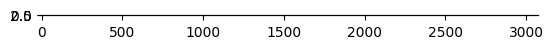

bird  bird  horse car  


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #get data from loader!

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Assignment: design MLP to classify CIFAR10

### E1 use TensorBoard to visualize the training

### E2 try two different Losses

### E3 try two different Optimizers
* SGD with Momentum
* AdaGrad or Adam

### E4 implement a learning rate schedule
* use SGD with Momentung as Optimizer
* use a Multi-step schedule

### Notes:
* USE THE GPU! -> need to transfer the model and data to the GPU
* MLP take 1D input - CIFAR imges are 2D -> first operator of your net needs to flatten the image
* CIFAR is a multi class problem: use a SOFTMAX layer to output vector of class propabilities -> user argmax to get the class lable
* Start small: use a small net with a reducet training set and a few epochs to test your setup

In [56]:
import torch.nn as nn

In [57]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(MLP, self).__init__()
    layers = []

    layers.append(nn.Linear(input_size, hidden_sizes[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_sizes)):
        layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    #layers.append(torch.nn.Softmax())

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [58]:
input_size = 3072
hidden_sizes = [512, 256]
output_size = 1

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"device: {device}")

model = MLP(input_size, hidden_sizes, output_size).to(device)
print(model)

In [61]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

epochs = 1
for epoch in range(epochs):
    total_loss = 0
    for images, labels in trainloader:
      images = images.view(images.size(0), -1)
      labels = labels.view(-1, 1).float()

      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()            # Clear gradients
      outputs = model(images)           # Forward pass
      loss = criterion(outputs, labels)  # Compute loss
      loss.backward()                  # Backpropagation
      optimizer.step()                 # Update weights

      total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/1, Loss: nan
